In [1]:
%%HTML
<video width="738" height="867" controls>
  <source src="covid-19_spread.mp4" type="video/mp4">
</video>

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, FFMpegWriter  
import datetime
import geopandas

In [3]:
# Want to see if I can find anything regarding cross province infections

patient = pd.read_csv("./data/PatientInfo.csv", index_col="patient_id")

# drop columns that I don't need for this
patient = patient[["province", "infected_by", "confirmed_date"]]

# infected_by has some dirty data in it, identifying them here
patient.index = patient.index.astype(str)

patient[patient.infected_by.notnull() & ~patient.infected_by.isin(patient.index.values)]

,province,infected_by,confirmed_date
patient_id,,,
1000000003,Seoul,2002000001,2020-01-30
1000000062,Seoul,2017000005,2020-02-28
5000000022,Jeollabuk-do,"1500000050, 1500000055",2020-06-17
5100000022,Jeollanam-do,12702,2020-06-27
5100000023,Jeollanam-do,12702,2020-06-27
6100000034,Gyeongsangnam-do,6100000384,2020-02-26
6100000035,Gyeongsangnam-do,6100000384,2020-02-26
6100000036,Gyeongsangnam-do,6100000384,2020-02-26


In [4]:
# Was able to find the proper fix for patient_id 1000000003
# https://www.straitstimes.com/asia/east-asia/wuhan-virus-south-korea-reports-first-local-human-to-human-transmission
patient.loc["1000000003"].infected_by = "2000000001"

# 1000000062 case was difficult to find any info on, and variants of 2017000005 didn't result in any patient
# ids with reasonable dates.  I decided to convert this into a NaN
patient.loc["1000000062"].infected_by = np.nan

# 5000000022 was simple to fix, this is the only case where there are 2 infected_by, and both 1500000050 and
# 1500000055 have the same province and infection_case, which means that the graph wouldn't be affected if we
# picked one
patient.loc["5000000022"].infected_by = "1500000050"

# 5100000022 and 5100000023, no idea how to fix these.  There are 2 options: 1. Attribute it to 5100000021 as
# it's the only other local case in a reasonable time frame, or, 2. Remove the attribution.  I will do 2 here.
patient.loc["5100000022"].infected_by = np.nan
patient.loc["5100000023"].infected_by = np.nan
patient.loc["5100000022"].infection_case = "etc"
patient.loc["5100000023"].infection_case = "etc"

# The last 3 patients in Gyeongsangnam-do were amongst a huge list of people that were tested in affiliation
# with the Shincheonji Church or in contact with them.  Seeing that members of the church were likely to be
# tagged with infection_case = Shincheonji Church, I opted to assign them to be infected by a confirmed case
# from the Shincheonji Church, rather than assigning them to the group.  Note: There was also a few affilited
# with Geochang Church but these were the people confirmed or showed symtoms in Geochang-gun, so I ruled that
# out.  Might be wrong but Shincheonji Church were responsible for majority of the spread during this period
# that adding 3 cases to their name will not be significant anyways, sorry patient # 6100000028!

patient.loc["6100000034"].infected_by = "6100000028"
patient.loc["6100000035"].infected_by = "6100000028"
patient.loc["6100000036"].infected_by = "6100000028"

# This should be empty now:
patient[patient.infected_by.notnull() & ~patient.infected_by.isin(patient.index.values)]

,province,infected_by,confirmed_date
patient_id,,,


In [5]:
# lat long data 
region = pd.read_csv("./data/Region.csv")
region = region[["city","latitude","longitude"]]

In [6]:
cross_province_spread = patient.merge(patient, how="left", right_index=True, left_on="infected_by")
cross_province_spread = cross_province_spread[(cross_province_spread.province_x != cross_province_spread.province_y) & cross_province_spread.province_y.notnull()].sort_values(by="confirmed_date_x")
cross_province_spread = cross_province_spread.rename(columns={"province_y": "from_province", "province_x": "to_province", "confirmed_date_x": "spread_date"}).reset_index()
cross_province_spread = cross_province_spread[["from_province", "to_province", "spread_date"]]
cross_province_spread["spread_date"] = cross_province_spread.spread_date.astype("datetime64[D]")

cross_province_spread = cross_province_spread.merge(region, how="left", right_on="city", left_on="from_province")
cross_province_spread = cross_province_spread.merge(region, how="left", right_on="city", left_on="to_province")

cross_province_spread = cross_province_spread[["spread_date","latitude_x","longitude_x","latitude_y","longitude_y"]]

cross_province_spread

,spread_date,latitude_x,longitude_x,latitude_y,longitude_y
0,2020-01-30,37.275119,127.009466,37.566953,126.977977
1,2020-02-06,35.160467,126.851392,34.816095,126.463021
2,2020-02-19,35.872150,128.601783,36.576032,128.505599
3,2020-02-21,35.872150,128.601783,37.275119,127.009466
4,2020-02-22,37.566953,126.977977,37.275119,127.009466
...,...,...,...,...,...
180,2020-06-24,36.350621,127.384744,36.658976,126.673318
181,2020-06-26,36.350621,127.384744,35.820308,127.108791
182,2020-06-26,37.566953,126.977977,37.275119,127.009466
183,2020-06-28,35.160467,126.851392,35.820308,127.108791


In [7]:
# 185 cases of movement between provinces

In [8]:
# Now let's get daily cases of each province, it'll be interesting to see if local cases increases after
# virus spreads from province to province.

province = pd.read_csv("./data/TimeProvince.csv")

# only use the useful columns
province = province[["date", "province", "confirmed"]]
province["date"] = province.date.astype("datetime64[D]")

province = province.pivot(index="date", columns="province", values="confirmed")

province = (province - province.shift(1))[1:]

# new cases per day per province, 7 day rolling average
province = province.rolling(7, min_periods=1).mean()

province = province.unstack().reset_index().rename(columns={0:"new_cases"})

province = province.merge(region, how="left", right_on="city", left_on="province")
province["new_cases"] = province.new_cases.clip(lower=0)
province["circle"] = province.new_cases**0.8 * 500 # adjusting circle sizes
province["color"] = np.log2(province.new_cases+1)
province = province.sort_values(by="new_cases", ascending=False)
province

,province,date,new_cases,city,latitude,longitude,circle,color
529,Daegu,2020-03-04,471.000000,Daegu,35.872150,128.601783,68768.053240,8.882643
530,Daegu,2020-03-05,456.571429,Daegu,35.872150,128.601783,67077.518673,8.837853
531,Daegu,2020-03-06,444.857143,Daegu,35.872150,128.601783,65697.139262,8.800438
528,Daegu,2020-03-03,436.857143,Daegu,35.872150,128.601783,64750.266046,8.774316
532,Daegu,2020-03-07,406.857143,Daegu,35.872150,128.601783,61167.898539,8.671920
...,...,...,...,...,...,...,...,...
2087,Jeollabuk-do,2020-06-12,0.000000,Jeollabuk-do,35.820308,127.108791,0.000000,0.000000
2088,Jeollabuk-do,2020-06-13,0.000000,Jeollabuk-do,35.820308,127.108791,0.000000,0.000000
2089,Jeollabuk-do,2020-06-14,0.000000,Jeollabuk-do,35.820308,127.108791,0.000000,0.000000
2090,Jeollabuk-do,2020-06-15,0.000000,Jeollabuk-do,35.820308,127.108791,0.000000,0.000000


In [9]:
# this is to use only a portion of the color map since the extremes are a bit hard to see on the map
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [10]:
krmap = geopandas.read_file("skorea-provinces-geo.json")

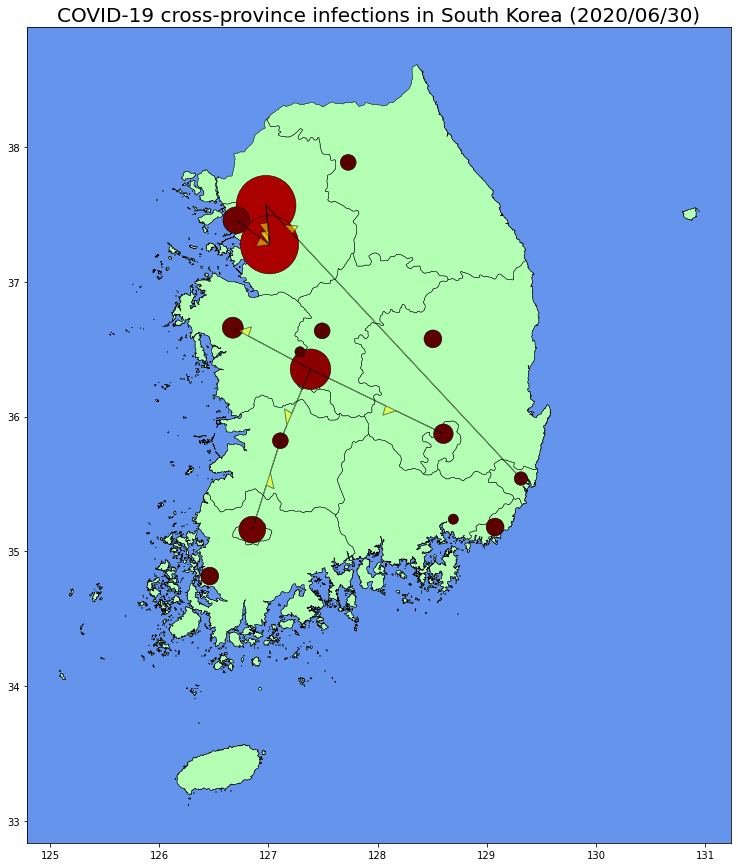

In [11]:
def draw_arrow(ax,x1,y1,x2,y2,p):
    a = ax.arrow(x = x1,
                 y = y1,
                 dx = (x2-x1)*p,
                 dy = (y2-y1)*p,
                 length_includes_head = True,
                 head_width = 0.15,
                 head_length = 0.1,
                 shape = 'left',
                 alpha = 0.5,
                 color="yellow",
                 ec="black",
                )
    b = ax.arrow(x = x1 + (x2-x1)*p,
                 y = y1 + (y2-y1)*p,
                 length_includes_head = True,
                 dx = x2-x1 - (x2-x1)*p,
                 dy = y2-y1 - (y2-y1)*p,
                 alpha = 0.5,
                 ec="black",
            )
    return (a,b)

cmax = max(province.color)

def draw_day(ax, p_df, c_df):
    p = ax.scatter(x=p_df.longitude, y=p_df.latitude, s=p_df.circle, c=p_df.color, edgecolor='k', linewidth=0.5,
                   cmap = truncate_colormap(plt.get_cmap("gist_heat"),0.2,0.8), vmin=0, vmax=cmax,
                  )
    drew = [p]
    for _,r in c_df.iterrows():
        ab = draw_arrow(ax, r.longitude_x, r.latitude_x, r.longitude_y, r.latitude_y, r.p)
        drew += ab
    return drew

fig, ax = plt.subplots(figsize=(15,15))
krmap.plot(ax=ax, edgecolor='k', color=(0.7, 1.0, 0.7) ,linewidth=0.5)
ax.set_facecolor((100/256,149/256,237/256))

dates = pd.date_range(start=min(province.date), end=max(province.date))
period = 7
stuff = []

def update(d):
    global stuff
    for s in stuff:
        s.remove()
    stuff = []

    df = province[province.date==d]
    df2 = cross_province_spread[cross_province_spread.spread_date.isin(pd.date_range(start=d-datetime.timedelta(days=period), periods=period*2))][:]
    df2["p"] = 1 - (df2.spread_date - d + datetime.timedelta(days=period)) / datetime.timedelta(days=period*2)
    stuff += draw_day(ax,df,df2)
    ax.set_title(f"COVID-19 cross-province infections in South Korea ({d.strftime('%Y/%m/%d')})", {'fontsize': 20})

ani = FuncAnimation(fig, update, dates)


writervideo = FFMpegWriter(fps=8)
ani.save("covid-19_spread.mp4", writer=writervideo)